#Installing biopython

In [1]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.5 MB/s eta 0:00:00


# Uploading Files

In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving AllProteinswithFunctions-Bakers Yeast (1).txt to AllProteinswithFunctions-Bakers Yeast (1).txt
Saving YEAST (1).fasta to YEAST (1).fasta


# Accuracy 71 percent using CNN

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [3]:
protein_functions_path = "AllProteinswithFunctions-Bakers Yeast (1).txt"
fasta_file_path = "YEAST (1).fasta"

def load_data():
    protein_functions = pd.read_csv(
        protein_functions_path,
        sep=";",
        header=None,
        names=["Protein_ID", "GO_Terms"],
        on_bad_lines='skip'
    )

    sequences = []
    sequence_ids = []
    for record in SeqIO.parse(fasta_file_path, "fasta"):
        if "|" in record.id:
            protein_id = record.id.split("|")[1]
        else:
            protein_id = record.id
        sequence_ids.append(protein_id)
        sequences.append(str(record.seq))

    sequence_data = pd.DataFrame({
        "Protein_ID": sequence_ids,
        "Sequence": sequences
    })

    return protein_functions, sequence_data



In [4]:
def extract_sequence_features(sequence):
    charge = {
        'D': -1, 'E': -1, 'K': 1, 'R': 1, 'H': 0.5,
        'A': 0, 'C': 0, 'F': 0, 'G': 0, 'I': 0,
        'L': 0, 'M': 0, 'N': 0, 'P': 0, 'Q': 0,
        'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0
    }

    flexibility = {
        'A': 0.36, 'C': 0.35, 'D': 0.51, 'E': 0.50, 'F': 0.31,
        'G': 0.54, 'H': 0.32, 'I': 0.46, 'K': 0.47, 'L': 0.37,
        'M': 0.30, 'N': 0.46, 'P': 0.51, 'Q': 0.49, 'R': 0.53,
        'S': 0.51, 'T': 0.44, 'V': 0.39, 'W': 0.31, 'Y': 0.42
    }


    charge_values = [charge.get(aa, 0) for aa in sequence]
    flexibility_values = [flexibility.get(aa, 0) for aa in sequence]

    n_term = sequence[:10]  # N-terminal region
    c_term = sequence[-10:]  # C-terminal region

    features = [
        np.mean(charge_values),
        np.std(charge_values),
        np.mean(flexibility_values),
        np.std(flexibility_values),
        sum(charge.get(aa, 0) for aa in n_term) / 10,  # N-terminal charge
        sum(charge.get(aa, 0) for aa in c_term) / 10,  # C-terminal charge
    ]

    return features


In [5]:

def normalize_sequence_features(features):
    # Normalize length
    features[0] = (features[0] - 100) / 1000
    return features


In [6]:

protein_functions, sequence_data = load_data()

merged_data = pd.merge(protein_functions, sequence_data, on="Protein_ID", how="inner")

merged_data["Label"] = merged_data["GO_Terms"].str.split(";").str[0]

label_counts = merged_data["Label"].value_counts()
valid_labels = label_counts[label_counts >= 30].index
filtered_data = merged_data[merged_data["Label"].isin(valid_labels)].copy()

X = np.array([normalize_sequence_features(extract_sequence_features(seq))
              for seq in filtered_data["Sequence"]])

scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_data["Label"])
y_categorical = to_categorical(y)



In [7]:
def create_model(input_dim, num_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(1024, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(512, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='selu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=0.001,
            weight_decay=0.001,
            beta_1=0.9,
            beta_2=0.999
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [8]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-8,
    verbose=1
)
fold_scores = []
histories = []
fold_reports = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, np.argmax(y_categorical, axis=1))):
    print(f'\nFold {fold + 1}/{n_folds}')

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_categorical[train_idx], y_categorical[val_idx]

    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = {}
    classes = np.unique(y_train_labels)
    class_counts = np.bincount(y_train_labels)
    total_samples = len(y_train_labels)

    for cls in classes:
        class_weights[cls] = total_samples / (len(classes) * class_counts[cls])

    model = create_model(X.shape[1], y_categorical.shape[1])

    history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        early_stopping,
        reduce_lr,
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            save_best_only=True,
            monitor='val_loss'
        )
    ],
    verbose=1
)
    scores = model.evaluate(X_val, y_val, verbose=0)
    fold_scores.append(scores)
    histories.append(history.history)

    # Classification report
    y_pred = model.predict(X_val)
    y_val_labels = np.argmax(y_val, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    report = classification_report(
        y_val_labels,
        y_pred_labels,
        target_names=label_encoder.classes_,
        zero_division=0
    )
    fold_reports.append(report)

    print(f'\nFold {fold + 1} Results:')
    print(f'Loss: {scores[0]:.4f}')
    print(f'Accuracy: {scores[1]:.4f}')
    print('\nClassification Report:')
    print(report)



Fold 1/5
Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 860ms/step - accuracy: 0.5053 - loss: 2.1699 - val_accuracy: 0.6415 - val_loss: 1.5805 - learning_rate: 0.0010
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6670 - loss: 1.6764 - val_accuracy: 0.5849 - val_loss: 1.4603 - learning_rate: 0.0010
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6426 - loss: 1.6511 - val_accuracy: 0.7358 - val_loss: 1.3759 - learning_rate: 0.0010
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6384 - loss: 1.5008 - val_accuracy: 0.7170 - val_loss: 1.4387 - learning_rate: 0.0010
Epoch 5/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6951 - loss: 1.4562 - val_accuracy: 0.6981 - val_loss: 1.3235 - learning_rate: 0.0010
Epoch 6/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7183 - loss: 1.4558 - val_accuracy: 0.7170 - val_loss: 1.2659 - learning_rate: 0.0010
Epoch 7/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6937 - loss: 1.4996 - val

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step

Fold 3 Results:
Loss: 1.0782
Accuracy: 0.7925

Classification Report:
              precision    recall  f1-score   support

  GO:0003677       0.40      0.67      0.50         6
  GO:0003723       0.93      0.70      0.80        20
  GO:0003735       0.86      0.89      0.87        27

    accuracy                           0.79        53
   macro avg       0.73      0.75      0.72        53
weighted avg       0.83      0.79      0.80        53


Fold 4/5
Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6257 - loss: 1.8895 - val_accuracy: 0.7308 - val_loss: 1.7801 - learning_rate: 0.0010
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6811 - loss: 1.5611 - val_accuracy: 0.7500 - val_loss: 1.5932 - learning_rate: 0.0010
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7073 - loss: 1.6068 - val_accuracy: 0.7500 - val_loss: 1.4754 - learning_rate: 0.0010
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

In [9]:
model.save(f'fold_{fold + 1}_model.keras')

In [10]:

avg_loss = np.mean([scores[0] for scores in fold_scores])
avg_accuracy = np.mean([scores[1] for scores in fold_scores])
std_loss = np.std([scores[0] for scores in fold_scores])
std_accuracy = np.std([scores[1] for scores in fold_scores])

print('\nOverall Results:')
print(f'Average Loss: {avg_loss * 100:.4f}% (±{std_loss:.4f})')
print(f'Average Accuracy: {avg_accuracy * 100:.2f}% (±{std_accuracy:.2f})')



Overall Results:
Average Loss: 143.9861% (±0.3145)
Average Accuracy: 72.66% (±0.08)


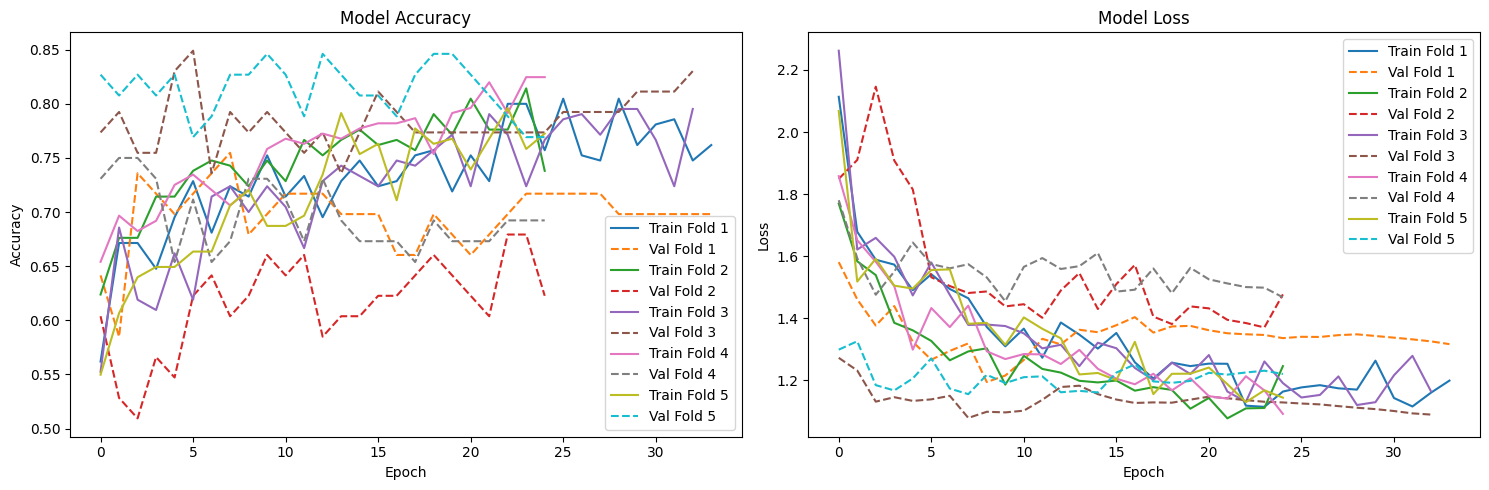

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for fold, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Train Fold {fold+1}')
    plt.plot(history['val_accuracy'], label=f'Val Fold {fold+1}', linestyle='--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
for fold, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Train Fold {fold+1}')
    plt.plot(history['val_loss'], label=f'Val Fold {fold+1}', linestyle='--')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()



plt.tight_layout()
plt.show()